## Installing all our relevant dependencies 


In [1]:
pip install tensorflow opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Importing standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

# importing deep learning related dependencies-Functional API
from tensorflow.keras.models import Model  
from tensorflow.keras.layers import Layer,Conv2D,Dense,MaxPooling2D,Input,Flatten 

import tensorflow as tf


### Creating the Folder Structure 

In [2]:
# setup paths 
POS_PATH=os.path.join('data','positive')
NEG_PATH=os.path.join('data','negative')
ANC_PATH=os.path.join('data','anchor')


### Making Directories Corresponsing To Path

In [ ]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [ ]:
# Open the video file
cap = cv2.VideoCapture(0)

# Check if the video file is opened successfully
if not cap.isOpened():
    print("Error: Could not open video file.")
    exit()

while True:
    # Read a frame from the video
    ret, frame = cap.read()

    # Check if frame is read successfully
    if not ret:
        print("Error: Could not read frame.")
        break

    # Modify RGB values for each pixel
    # For example, let's make the frame grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Display the modified frame
    cv2.imshow('Modified Frame', gray_frame)

    # Exit the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()

In [ ]:
plt.imshow(frame) # to check weather the frame is captured or not 

### Bringing the Images into the Dimension of 250*250

In [6]:
cap=cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame=cap.read()

    # cut down the frame to 250*250
    frame=frame[120:120+250,200:200+250,:]
    
    cv2.imshow('Image Collection',frame) 
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release() 
cv2.destroyAllWindows()
    

In [ ]:
ple.imshow(frame)

In [3]:
# importing the uuid library => to generate unique image names
import uuid # uniform unique identifier

### Using Open-Cv For Collecting Images of Different Categories 

In [2]:

cap=cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame=cap.read()

    # cut down the frame to 250*250
    frame=frame[120:120+250,200:200+250,:]


    # collect anchors 
    if cv2.waitKey(1) & 0xFF == ord('a'):
        # create the unique name 
        imgname=os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
        # write out that image 
        cv2.imwrite(imgname,frame)



    # collect positive images 
    if cv2.waitKey(1) & 0xFF==ord('p'):
        # create a unique id 
        imgname=os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
        #write out that imege
        cv2.imwrite(imgname,frame)
   
    cv2.imshow('Image Collection',frame) 
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break
cap.release() 
cv2.destroyAllWindows()

## Preprocessing Images 

### Get Image Directories

In [7]:
anchor=tf.data.Dataset.list_files(ANC_PATH+'\*jpg').take(300)
positive=tf.data.Dataset.list_files(POS_PATH+'\*jpg').take(300)
negative=tf.data.Dataset.list_files(NEG_PATH+'\*jpg').take(300)
'''
    Here we are creating three different datset or three different pipeline 
    This is going to grab first 300 images from all the files mentioned 
'''

'\n    Here we are creating three different datset or three different pipeline \n    This is going to grab first 300 images from all the files mentioned \n'

In [8]:
dir_test=anchor.as_numpy_iterator() # we are eventually iterating over the data pipeline 

In [9]:
print(dir_test.next())

b'data\\anchor\\85b147a0-d884-11ee-a8f5-80e82c6f74bc.jpg'


### Pre-Processing -Scale and Resize

This pre-process function over here actually takes the file from the dataset which is being entered 
<br />
It opens the image decodes it and resize it to the desired size 

In [10]:
def preprocess(file_path):
    byte_img=tf.io.read_file(file_path)  # read the image from the file path 
    img=tf.io.decode_jpeg(byte_img) # decode jpeg image # the byte img converted to jpeg

    # Pre-Processing steps-resizing the image to be 100x100x3
    img=tf.image.resize(img,(100,100))
    img=img/255.0
    return img
    

In [11]:
img=preprocess('data\\anchor\\f8f94e69-d885-11ee-bb4a-80e82c6f74bc.jpg')

In [12]:
img.numpy().max()

0.8779412

plt.imshow(img)

### Creating a Labelled Dataset

In [14]:
tf.ones_like(1)

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [15]:
positives=tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))

negatives=tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data=positives.concatenate(negatives) # combining the above two dataset 



(Zip) => this function over here combines the dataset length wise here it is combining anchor dataset positive dataset and label dataset
<br />

data.Dataset.from_tensor_slices(tf.ones(len(anchor)) => this is actually creating the new dataset from the tensor's of one's which has a length
of the anchor dataset Each element in this dataset represents a label for a positive pair 

### Build Train and Test Partition 

The preprocess_twin function takes three inputs: 
<br />

input_img, validation_img, and label, and applies the preprocess function to each input image. 
<br />

It returns a tuple containing the preprocessed versions of the input and validation images along with the label. 

In [16]:
samples=data.as_numpy_iterator()

In [17]:
example=samples.next()

In [18]:
example

(b'data\\anchor\\046acd8e-d886-11ee-b7bd-80e82c6f74bc.jpg',
 b'data\\positive\\bc4d3f02-d884-11ee-ba3a-80e82c6f74bc.jpg',
 1.0)

### Build Train and Test Partition


In [19]:
def preprocess_twin(input_img,validation_img,label):
    return(preprocess(input_img),preprocess(validation_img),label)

In [20]:
res=preprocess_twin(*example)  # * is unpacking the value and process it through our function 

plt.imshow(res[1])

In [22]:
# we are going to make the data pipeline over here 
data=data.map(preprocess_twin)
data=data.cache() 
data=data.shuffle(buffer_size=10000) 

In [23]:
samples=data.as_numpy_iterator()
# this would grab the dataset with three columns the first columns contains the value for the anchor image 
# second one is for the positive 

In [24]:
len(samples.next())

3

In [25]:
samp=samples.next()

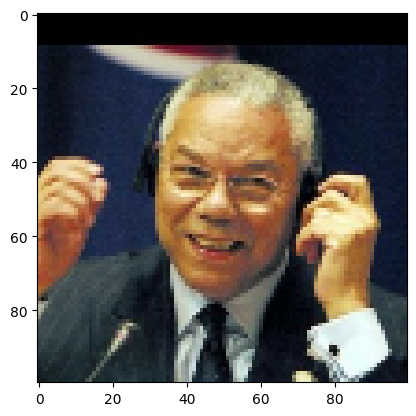

In [26]:
plt.imshow(samp[1])

In [27]:
samp[2]

0.0

### Training and Testing Partition

In [28]:
# Creating the training and testing partition 
# train-partition
train_data=data.take(round(len(data)*.7))
train_data=train_data.batch(16) 
train_data=train_data.prefetch(8) 

In [29]:
train_sample=train_data.as_numpy_iterator()

In [30]:
train_sample=train_sample.next()


In [31]:
# testing partition 
test_data=data.skip(round(len(data)*.7))
test_data=test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Building the Siamese Network


### Building our Embedding Layer 

In [38]:
inp=Input(shape=(100,100,3),name='input_image')

In [39]:
inp

<KerasTensor shape=(None, 100, 100, 3), dtype=float32, sparse=None, name=input_image>

In [40]:
c1=Conv2D(64,(10,10),activation='relu')(inp)

In [41]:
c1

<KerasTensor shape=(None, 91, 91, 64), dtype=float32, sparse=False, name=keras_tensor>

In [42]:

m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [43]:
m1

<KerasTensor shape=(None, 46, 46, 64), dtype=float32, sparse=False, name=keras_tensor_1>

In [44]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [45]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [46]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [47]:

mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [48]:

mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:

def make_embedding(): 
    inp = Input(shape=(100, 100, 3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D((2, 2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D((2, 2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D((2, 2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    # Define the model
    embedding_model = Model(inputs=inp, outputs=d1, name='embedding')
    
    return embedding_model


In [34]:
embedding=make_embedding()
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

### Build Distance Layer 

In [36]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, inputs):
        input_embedding,validation_embedding=inputs
        return tf.abs(input_embedding - validation_embedding)

In [37]:
l1=L1Dist()

In [38]:
l1

<L1Dist name=l1_dist, built=False>

### Make a Siamese Model

In [87]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [88]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)



In [89]:
inp_embedding

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_46>

In [90]:
siamese_layer = L1Dist()

In [91]:
distances = siamese_layer([inp_embedding, val_embedding])

In [76]:

siamese_model = make_siamese_model()

In [77]:
def make_siamese_model(): 
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Get embeddings for input and validation images
    input_embedding = embedding(input_image)
    validation_embedding = embedding(validation_image)
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer([input_embedding, validation_embedding])
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [78]:

siamese_model = make_siamese_model()

In [79]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_4 (L1Dist)  │ (None, 4096)      │          0 │ embedding[4][0],  │
│                     │                   │            │ embedding[5][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

## Training a Siamese Model

### Setup Loss and Optimizer 

In [80]:
binary_cross_loss=tf.losses.BinaryCrossentropy()# that's how we set our loss function 


In [81]:
# define the optimsizer : We are going to use the Adam Optimizer here 
opt=tf.keras.optimizers.Adam(1e-4) # 0.0001


### Establish Checkpoints


In [82]:
checkpoint_dir='./training_checkpoints' # we are defining the checkpoint folder
checkpoint_prefix=os.path.join(checkpoint_dir,'ckpt')
checkpoint=tf.train.Checkpoint(siamese_model=siamese_model)

### Build Train Step Function 

The basic flow for training on one batch is as follows :
1. Make Prediction 
2. Calculate loss
3. Derive gradients
4. Calculate new weights and apply 

In [83]:

test_batch = train_data.as_numpy_iterator()

In [84]:


def resize_images(images):
    # Ensure that the input tensor has 4 dimensions
    if len(images.shape) == 1:
        images = tf.expand_dims(images, axis=0)  # Add batch dimension
    elif len(images.shape) == 3:
        images = tf.expand_dims(images, axis=0)  # Add batch dimension
        
    # Resize the images
    resized_images = tf.image.resize(images, (100, 100))
    
    # Ensure that the output tensor has 4 dimensions if the input tensor had 4 dimensions
    if len(images.shape) == 4:
        resized_images = tf.squeeze(resized_images, axis=0)  # Remove batch dimension if present
    
    return resized_images

In [85]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [86]:
# so we are bulding the super resolution model 
# This function is focussed over one batch
# we will wrap everything inside the @tf.function it compiles the function into the callable Tensorflow Graph
@tf.function
def train_step(batch):
    
    with tf.GradientTape() as tape:
        X=resize_images(tf.convert_to_tensor(batch[:2])) # this gets the anchor and positive/negative imae 
        y=batch[2] # this gets the label
        
        # print("Shape of input images :",X.shape)
        # Forward Pass
        yhat=siamese_model(X,training=True) 
        # super imp to set the training layer to true because certain layers are activated only when it's set to true 
        # calculate loss
        loss=binary_cross_loss(y,yhat)
        # Each batch in the dataset is compromised of 16 samples,each of which contains an anchor image,a positive or negative image and a label

        # calculate gradients
    grad=tape.gradient(loss,siamese_model.trainable_variables)
        #calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))
    return loss

In [87]:
tf.losses.BinaryCrossentropy??

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x0000019B2FA030A0>>
Traceback (most recent call last):
  File "c:\Users\HP\OneDrive\Desktop\M\NND_Project\NND_Project_Siamese_Neural_Network\faceid\lib\site-packages\ipykernel\ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='binary_crossentropy',
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
        floating-point value which either represents a
        [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
        when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
        `from_logits=False`).

    Args:
        from_logits: Whether to interpret `y_pred` as a tensor of
            [logit](https://en.wikipedi

### Building the Training Loop

In [ ]:

# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall


In [ ]:
# This function over here is focussed over every batch in the dataset
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        r = Recall()
        p = Precision()
        
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            yhat = siamese_model(resize_images(batch[:2]), training=False)
            print("Shape of predicted outputs:", yhat.shape)
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)


In [ ]:

def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

### Train the Model

In [ ]:
EPOCHS=50
train(train_data,EPOCHS)


 Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/stepp
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━

## Evaluate Models

### Import Metrics 



In [ ]:

# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

### Make Predictions 

In [ ]:

# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()


In [ ]:

y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


In [ ]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1]

In [ ]:
y_true

array([0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
      dtype=float32)

### Calculate Metrics 

In [ ]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()


1.0

In [ ]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [ ]:
r = Recall()
p = Precision()
# recall and precision being higher value is better 
for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1.0 1.0


### Viz Results 


plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.imshow(test_input[2])

plt.subplot(1,2,2)
plt.imshow(test_val[2])

plt.show()

! Run This to Compare and Check the Results

In [ ]:
y_true

array([0., 1., 1., 1.], dtype=float32)

In [ ]:
y_hat

array([[8.6772707e-12],
       [3.5665093e-05],
       [9.9999952e-01],
       [1.2923982e-09],
       [9.5273572e-12],
       [5.3427623e-08],
       [9.9999845e-01],
       [8.3354657e-08],
       [2.2545261e-09],
       [1.0000000e+00],
       [5.2568559e-14],
       [2.6944114e-09],
       [1.0700595e-12],
       [3.5168418e-10],
       [7.8178402e-07],
       [9.9991447e-01]], dtype=float32)

## Save the Model

In [ ]:
# siamese_model.save('siamese_model.h5')
siamese_model.save('siamese_model.keras')

In [ ]:

# Reload Model
model = tf.keras.models.load_model('siamese_model.keras', custom_objects={'L1Dist': L1Dist})

In [88]:
model.predict([test_input,test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


array([[0.50093186],
       [0.50093186],
       [0.50093186],
       [0.50093186]], dtype=float32)

In [89]:
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

## Real-Time Test

#### Verification Function

In [90]:
def verify(frame,model,detection_threshold,verification_threshold):
    # build results array
    results=[]
    # looping through every image of the directory in verification_images
    
    for image in os.listdir(os.path.join('application_data','verification_images')):
        input_img=preprocess(os.path.join('application_data','input_image','input_image.jpg'))
        validation_img=preprocess(os.path.join('application_data','verification_images',image))
        
        result=model.predict(list(np.expand_dims([input_img,validation_img],axis=1)))
        results.append(result)
        
    
    detection=np.sum(np.array(results)>detection_threshold)
    verification=detection/len(os.listdir(os.path.join('application_data','verification_images')))
    verified=verification>verification_threshold
    return results,verified
# detection_threshold : metric over which the prediction is considered positive 
#verification threshold : proportion of positive predictions / positive samples 


### OpenCV Real Time Verification Images 

In [2]:
cap=cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame=cap.read()
    frame=frame[120:120+250,200:200+250,:]
    cv2.imshow('Verification',frame)
    
    # verification trigger:
    if cv2.waitKey(10) & 0xFF==ord('v'):
        # Save the input image to input image folder 
        cv2.imwrite(os.path.join('application_data','input_image','input_image_jpg'),frame)
        # verification image 
        results,verified=verify(frame,model,0.9,0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF==ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

NameError: name 'cv2' is not defined

In [ ]:
model.summary()